In [1]:
import json
import numpy as np
import scipy.stats
import statistics
from tabulate import tabulate

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

import matplotlib
matplotlib.rcParams['text.usetex'] = True
plt.rc('font', family='serif', serif=['Times'])

In [2]:
def text_correct(result):
    return result["c0_i0"] > result["c1_i0"] and result["c1_i1"] > result["c0_i1"]

def image_correct(result):
    return result["c0_i0"] > result["c0_i1"] and result["c1_i1"] > result["c1_i0"]

def group_correct(result):
    return image_correct(result) and text_correct(result)

def load_results(filename):
    results = {}
    for line in open(filename, "r").readlines():
        score_dict = json.loads(line)
        id, c, i = score_dict["label"].split("_")
        id = int(id)
        scores = results.get(id, {})
        scores["_".join([c,i])] = score_dict["score"]
        results[id] = scores
    return results

def filter_examples(filter_dict):
    examples = [json.loads(line) for line in open("../data/winoground/data/examples.jsonl").readlines()]
    def filter_criteria(example):
        for key, value in filter_dict.items():
            if example[key] != value:
                return False
        return True
    filtered_ids = {example["id"] for example in filter(filter_criteria, examples)}
    return filtered_ids

def get_table_dict(models, filtered_ids=None, bootstrap_confidence_intervals=False):

    table_dict = {"Model": [], "Text": [], "Image": [], "Group": []}
    for filename, display_name, _, _, _ in models:
        results = load_results(filename)
        if filtered_ids is not None:
            filtered_results = {}
            for key, value in results.items():
                if key in filtered_ids:
                    filtered_results[key] = value
            results = filtered_results

        text_results = [text_correct(result) for result in results.values()]
        image_results = [image_correct(result) for result in results.values()]
        group_results = [group_correct(result) for result in results.values()]
        if bootstrap_confidence_intervals:
            text_bootstrap_result = scipy.stats.bootstrap(data=(text_results,), statistic=scipy.mean)
            image_bootstrap_result = scipy.stats.bootstrap(data=(image_results,), statistic=scipy.mean)
            group_bootstrap_result = scipy.stats.bootstrap(data=(group_results,), statistic=scipy.mean)
            text_score = "{:0.2f}".format(100*statistics.mean(text_results))\
                + " & [" + "{:0.2f}".format(100*text_bootstrap_result.confidence_interval.low)\
                + "," + "{:0.2f}".format(100*text_bootstrap_result.confidence_interval.high) + "]"
            image_score = "{:0.2f}".format(100*statistics.mean(image_results))\
                + " & [" + "{:0.2f}".format(100*image_bootstrap_result.confidence_interval.low)\
                + "," + "{:0.2f}".format(100*image_bootstrap_result.confidence_interval.high) + "]"
            group_score = "{:0.2f}".format(100*statistics.mean(group_results))\
                + " & [" + "{:0.2f}".format(100*group_bootstrap_result.confidence_interval.low)\
                + "," + "{:0.2f}".format(100*group_bootstrap_result.confidence_interval.high) + "]"
        else:
            text_score = 100*statistics.mean(text_results)
            image_score = 100*statistics.mean(image_results)
            group_score = 100*statistics.mean(group_results)
        table_dict["Model"].append(display_name)
        table_dict["Text"].append(text_score)
        table_dict["Image"].append(image_score)
        table_dict["Group"].append(group_score)

    return table_dict


In [3]:
basedir = "../outputs/Winoground"

model_to_name = {
    "albef_4m": "ALBEF$_{4M}$",
    "albef_14m": "ALBEF$_{14M}$",
    "blip_14m": "BLIP$_{14M}$",
    "blip_129m": "BLIP$_{129M}$",
    "blip_capfiltl_129m": "BLIP$_{129M}$+CapFilt-L",
    "blip_vitl_129m": "BLIP-ViT/L$_{129M}$",
    "pevl_pretraining": "PEVL$_{pretrain}$",
    "pevl_grounding": "PEVL$_{grounding}$",
    "pevl_vrd": "PEVL$_{vrd}$",
    "x-vlm_4m": "X-VLM$_{4M}$",
    "x-vlm_16m": "X-VLM$_{16M}$",
    "clipcap_cc": "clipcap$_{CC3M}$",
    "clipcap_coco": "clipcap$_{COCO}$",
    "blip2_itm_pretrain": "BLIP-2",
}

fn_template = "../outputs/Winoground/%s/%s.jsonl"
models = [(fn_template % (m, m), model_to_name[m], None, None, None)
                     for m in model_to_name]

In [4]:
# Overall
print(tabulate(get_table_dict(models), floatfmt=".2f"))  # tablefmt="latex_raw"

-----------------------  -----  -----  -----
ALBEF$_{4M}$             29.25  15.50  11.00
ALBEF$_{14M}$            32.75  16.50  12.50
BLIP$_{14M}$             36.50  18.50  14.50
BLIP$_{129M}$            35.50  15.00  11.75
BLIP$_{129M}$+CapFilt-L  34.75  15.25  12.25
BLIP-ViT/L$_{129M}$      34.75  14.50  12.25
PEVL$_{pretrain}$        33.25  15.75  12.25
PEVL$_{grounding}$       36.25  15.00  12.00
PEVL$_{vrd}$             31.25  12.00   7.50
X-VLM$_{4M}$             44.00  26.75  21.50
X-VLM$_{16M}$            46.75  24.50  21.25
clipcap$_{CC3M}$         12.25  14.75   5.50
clipcap$_{COCO}$         13.50  14.00   5.50
BLIP-2                   43.00  22.00  18.25
-----------------------  -----  -----  -----


In [5]:
# Linguistic
linguistic_table_dict = get_table_dict(models, filter_examples(filter_dict={"collapsed_tag": "Object"}))
relation_table_dict = get_table_dict(models, filter_examples(filter_dict={"collapsed_tag": "Relation"}))
linguistic_table_dict["Text2"] = relation_table_dict["Text"]
linguistic_table_dict["Image2"] = relation_table_dict["Image"]
linguistic_table_dict["Group2"] = relation_table_dict["Group"]
both_table_dict = get_table_dict(models, filter_examples(filter_dict={"collapsed_tag": "Both"}))
linguistic_table_dict["Text3"] = both_table_dict["Text"]
linguistic_table_dict["Image3"] = both_table_dict["Image"]
linguistic_table_dict["Group3"] = both_table_dict["Group"]
main_pred1_table_dict = get_table_dict(models, filter_examples(filter_dict={"num_main_preds": 1}))
linguistic_table_dict["Text4"] = main_pred1_table_dict["Text"]
linguistic_table_dict["Image4"] = main_pred1_table_dict["Image"]
linguistic_table_dict["Group4"] = main_pred1_table_dict["Group"]
main_pred2_table_dict = get_table_dict(models, filter_examples(filter_dict={"num_main_preds": 2}))
linguistic_table_dict["Text5"] = main_pred2_table_dict["Text"]
linguistic_table_dict["Image5"] = main_pred2_table_dict["Image"]
linguistic_table_dict["Group5"] = main_pred2_table_dict["Group"]
print(tabulate(linguistic_table_dict, floatfmt=".2f"))  # tablefmt="latex_raw"

-----------------------  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----
ALBEF$_{4M}$             29.79  12.77   8.51  26.61  15.02  10.73  50.00  34.62  26.92  33.22  19.52  14.04  18.52   4.63   2.78
ALBEF$_{14M}$            30.50  16.31   9.22  30.90  14.16  12.02  61.54  38.46  34.62  35.27  18.49  13.70  25.93  11.11   9.26
BLIP$_{14M}$             40.43  24.11  17.73  32.62  14.16  11.16  50.00  26.92  26.92  42.12  21.92  18.15  21.30   9.26   4.63
BLIP$_{129M}$            37.59  17.02  10.64  34.76  12.02  10.73  30.77  30.77  26.92  40.07  18.84  14.73  23.15   4.63   3.70
BLIP$_{129M}$+CapFilt-L  34.04  16.31  11.35  33.48  13.30  11.16  50.00  26.92  26.92  38.70  19.18  15.41  24.07   4.63   3.70
BLIP-ViT/L$_{129M}$      35.46  16.31  13.48  32.62  12.88  11.59  50.00  19.23  11.54  39.04  17.81  15.07  23.15   5.56   4.63
PEVL$_{pretrain}$        31.21  14.89  10.64  33.48  14.59  11.59  42.31  30.77  26.92  36.30  19

In [6]:
# Visual
visual_table_dict = get_table_dict(models, filter_examples(filter_dict={"secondary_tag": "Symbolic"}))
pragmatics_table_dict = get_table_dict(models, filter_examples(filter_dict={"secondary_tag": "Pragmatics"}))
visual_table_dict["Text2"] = pragmatics_table_dict["Text"]
visual_table_dict["Image2"] = pragmatics_table_dict["Image"]
visual_table_dict["Group2"] = pragmatics_table_dict["Group"]
series_table_dict = get_table_dict(models, filter_examples(filter_dict={"secondary_tag": "Series"}))
visual_table_dict["Text3"] = series_table_dict["Text"]
visual_table_dict["Image3"] = series_table_dict["Image"]
visual_table_dict["Group3"] = series_table_dict["Group"]
print(tabulate(visual_table_dict, floatfmt=".2f"))  # tablefmt="latex_raw"

-----------------------  -----  -----  -----  -----  -----  -----  -----  -----  -----
ALBEF$_{4M}$             42.86  21.43  17.86  17.65  17.65   5.88   8.70   4.35   0.00
ALBEF$_{14M}$            39.29  14.29  14.29  17.65  11.76   0.00  26.09   4.35   4.35
BLIP$_{14M}$             39.29  25.00  17.86  23.53  17.65  17.65   8.70   4.35   0.00
BLIP$_{129M}$            57.14  14.29  14.29  35.29  11.76  11.76  26.09   0.00   0.00
BLIP$_{129M}$+CapFilt-L  50.00  14.29  14.29  35.29   5.88   5.88  21.74   0.00   0.00
BLIP-ViT/L$_{129M}$      39.29  14.29  14.29  29.41   0.00   0.00  13.04   0.00   0.00
PEVL$_{pretrain}$        35.71  14.29  14.29  29.41  11.76   5.88  13.04   8.70   4.35
PEVL$_{grounding}$       35.71   7.14   7.14  29.41  11.76  11.76  26.09   8.70   4.35
PEVL$_{vrd}$             42.86  10.71   7.14  23.53   5.88   0.00  34.78  17.39   8.70
X-VLM$_{4M}$             50.00  32.14  32.14  41.18  23.53  17.65  30.43  26.09  13.04
X-VLM$_{16M}$            42.86  21.43  17.8

## ALBEF reproduction

In [7]:
models = []

num_epochs = 30

for e in range(num_epochs):
    models.append(
        (f"../outputs/Winoground/albef_4m_ours/albef_4m_ours_{e:02d}.jsonl",
        f"ALBEF$_{e:02d}$", None, None, None)
    )

In [8]:
overall_table_dict = get_table_dict(models)

# Linguistic
linguistic_table_dict = get_table_dict(models, filter_examples(filter_dict={"collapsed_tag": "Object"}))
relation_table_dict = get_table_dict(models, filter_examples(filter_dict={"collapsed_tag": "Relation"}))
linguistic_table_dict["Text2"] = relation_table_dict["Text"]
linguistic_table_dict["Image2"] = relation_table_dict["Image"]
linguistic_table_dict["Group2"] = relation_table_dict["Group"]
both_table_dict = get_table_dict(models, filter_examples(filter_dict={"collapsed_tag": "Both"}))
linguistic_table_dict["Text3"] = both_table_dict["Text"]
linguistic_table_dict["Image3"] = both_table_dict["Image"]
linguistic_table_dict["Group3"] = both_table_dict["Group"]
main_pred1_table_dict = get_table_dict(models, filter_examples(filter_dict={"num_main_preds": 1}))
linguistic_table_dict["Text4"] = main_pred1_table_dict["Text"]
linguistic_table_dict["Image4"] = main_pred1_table_dict["Image"]
linguistic_table_dict["Group4"] = main_pred1_table_dict["Group"]
main_pred2_table_dict = get_table_dict(models, filter_examples(filter_dict={"num_main_preds": 2}))
linguistic_table_dict["Text5"] = main_pred2_table_dict["Text"]
linguistic_table_dict["Image5"] = main_pred2_table_dict["Image"]
linguistic_table_dict["Group5"] = main_pred2_table_dict["Group"]

# Visual
visual_table_dict = get_table_dict(models, filter_examples(filter_dict={"secondary_tag": "Symbolic"}))
pragmatics_table_dict = get_table_dict(models, filter_examples(filter_dict={"secondary_tag": "Pragmatics"}))
visual_table_dict["Text2"] = pragmatics_table_dict["Text"]
visual_table_dict["Image2"] = pragmatics_table_dict["Image"]
visual_table_dict["Group2"] = pragmatics_table_dict["Group"]
series_table_dict = get_table_dict(models, filter_examples(filter_dict={"secondary_tag": "Series"}))
visual_table_dict["Text3"] = series_table_dict["Text"]
visual_table_dict["Image3"] = series_table_dict["Image"]
visual_table_dict["Group3"] = series_table_dict["Group"]

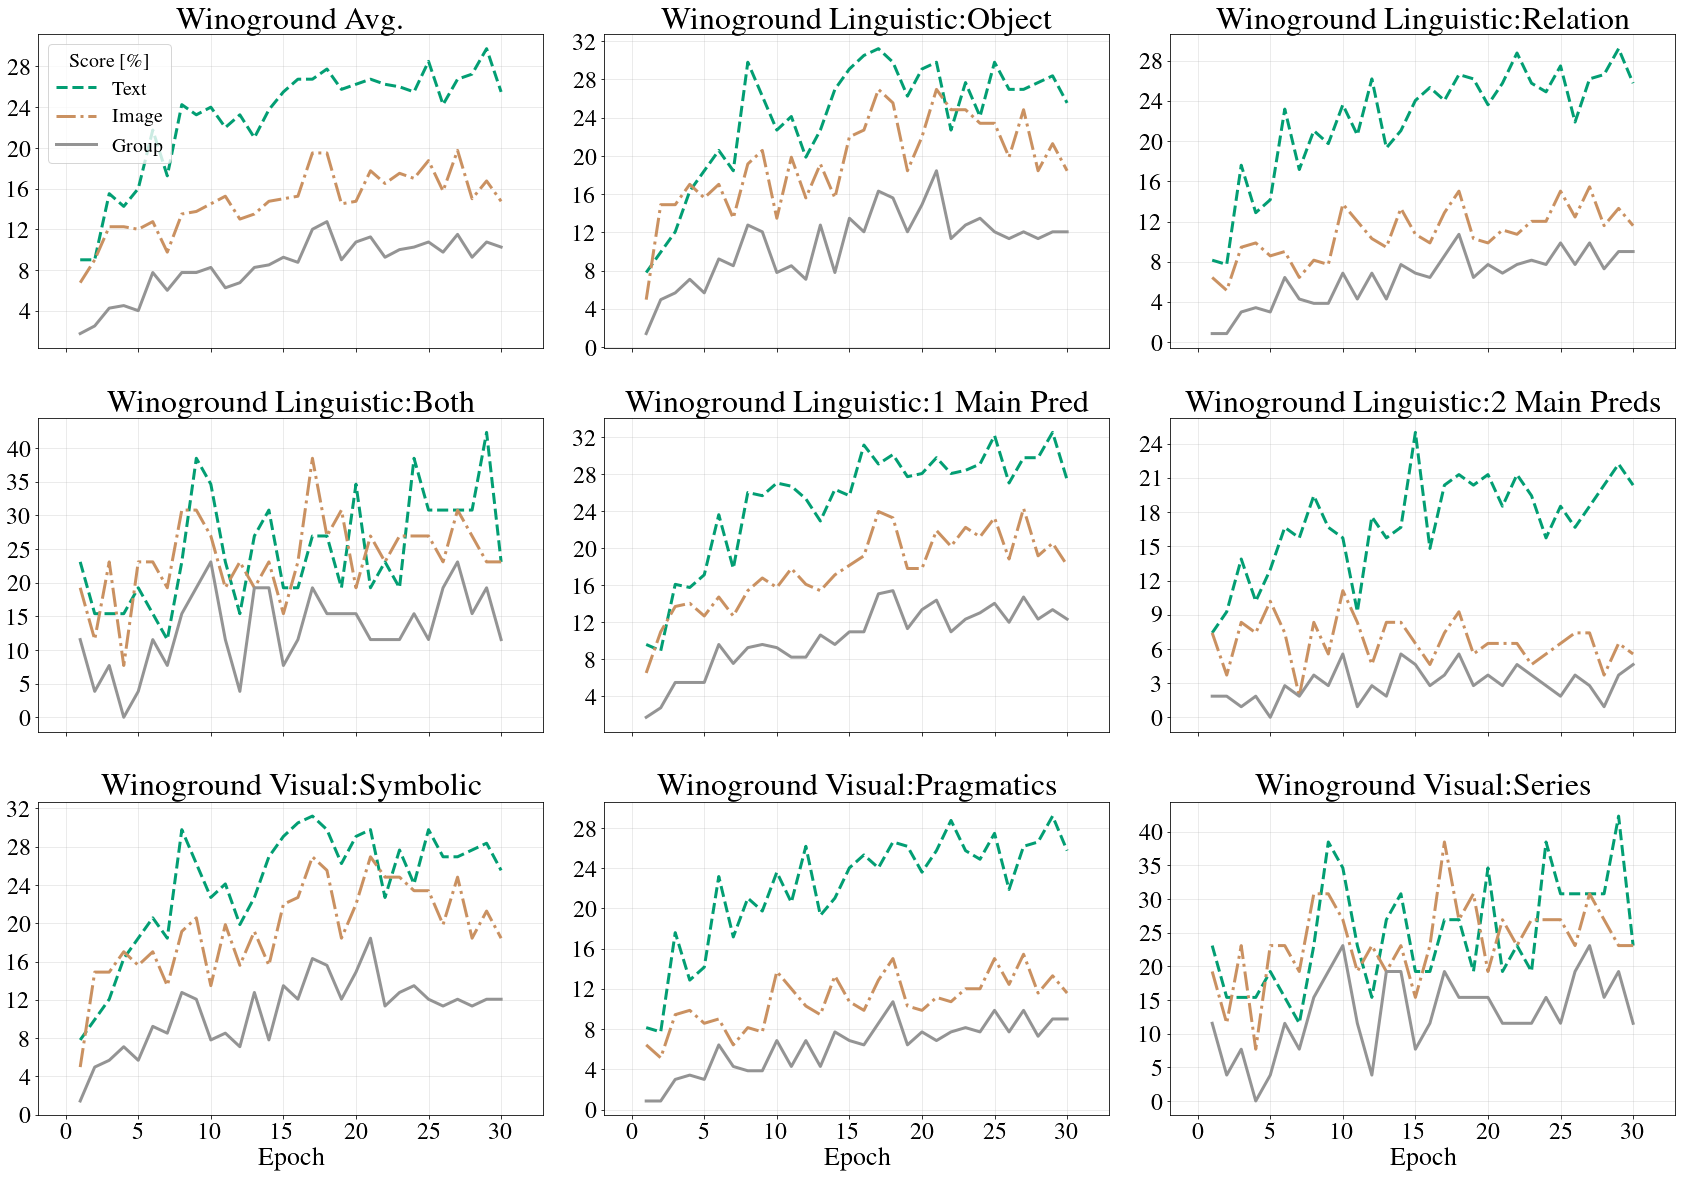

In [17]:
def ax_plot(ax, d, keys, title, print_xlabel=False):
    ax.plot(np.arange(1, num_epochs+1), d[keys[0]], linestyle='--', lw=3,
            color=sns.color_palette('colorblind')[2], label='Text')
    ax.plot(np.arange(1, num_epochs+1), d[keys[1]], linestyle='-.', lw=3,
            color=sns.color_palette('colorblind')[5], label='Image')
    ax.plot(np.arange(1, num_epochs+1), d[keys[2]], linestyle='-', lw=3,
            color=sns.color_palette('colorblind')[7], label='Group')
    if print_xlabel:
        ax.set_xlabel('Epoch', fontdict={'fontsize': 26})
    ax.set_title(title, fontsize=32)
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.grid(alpha=0.3)
    ax.margins(x=0.1)
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))


f, axs = plt.subplots(3, 3, figsize=(24,17), sharex=True)

# Overall
ax_plot(axs[0][0], overall_table_dict, ['Text', 'Image', 'Group'], 'Winoground Avg.')
axs[0][0].legend(title='Score [\%]', fontsize=20, title_fontsize=20)

# Linguistic-Object
ax_plot(axs[0][1], linguistic_table_dict, ['Text', 'Image', 'Group'], 'Winoground Linguistic:Object')

# Linguistic-Relation
ax_plot(axs[0][2], linguistic_table_dict, ['Text2', 'Image2', 'Group2'], 'Winoground Linguistic:Relation')

# Linguistic-Both
ax_plot(axs[1][0], linguistic_table_dict, ['Text3', 'Image3', 'Group3'], 'Winoground Linguistic:Both')

# Linguistic-1main
ax_plot(axs[1][1], linguistic_table_dict, ['Text4', 'Image4', 'Group4'], 'Winoground Linguistic:1 Main Pred')

# Linguistic-2main
ax_plot(axs[1][2], linguistic_table_dict, ['Text5', 'Image5', 'Group5'], 'Winoground Linguistic:2 Main Preds')

# Visual-symbolic
ax_plot(axs[2][0], linguistic_table_dict, ['Text', 'Image', 'Group'], 'Winoground Visual:Symbolic', print_xlabel=True)

# Visual-pragmatics
ax_plot(axs[2][1], linguistic_table_dict, ['Text2', 'Image2', 'Group2'], 'Winoground Visual:Pragmatics', print_xlabel=True)

# Visual-series
ax_plot(axs[2][2], linguistic_table_dict, ['Text3', 'Image3', 'Group3'], 'Winoground Visual:Series', print_xlabel=True)

f.tight_layout(pad=3.0)
# f.savefig('albef_winoground.pdf', bbox_inches='tight')